# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [1]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts

In [2]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [3]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [4]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [5]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [6]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4097 sha256=e677558b3e1b4a62a8d98fec2707f72799bd6102f7795056656ae90d950f4914
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gTTS-token


Importation of modules and packages. 

In [7]:
import io

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

# import warnings
# warnings.filterwarnings('ignore')

import missingno as msno
# import ppscore as pps

import dill

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Setting pandas display options

In [8]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [9]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [10]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Data is composed of 9 distinct .csv files, that we'll load in a dictionnary of dataframes.

In [66]:
# from datetime import strptime

if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [67]:
df_orders[['order_purchase_timestamp', 'shipping_limit_date']] = \
    df_orders[['order_purchase_timestamp', 'shipping_limit_date']]\
        .apply(lambda x: pd.to_datetime(x))
df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  

In [68]:
df_orders.dtypes

customer_unique_id                   object
customer_zip_code_prefix              int64
customer_city                        object
customer_state                       object
order_status                         object
delivered                             int64
order_purchase_timestamp     datetime64[ns]
shipping_limit_date          datetime64[ns]
shipping_time               timedelta64[ns]
shipping_delay              timedelta64[ns]
order_item_nb                       float64
mean_prod_descr_length              float64
cat_home                            float64
cat_multimedia                      float64
cat_hygiene                         float64
cat_office                          float64
cat_furniture                       float64
cat_food                            float64
cat_fashion                         float64
cat_electronics                     float64
cat_diy                             float64
cat_books                           float64
cat_miscellaneous               

In [ ]:
speak('Dataset successfully imported')

## 1 Aggregation at the Customer level

Let's now aggregate all the orders to get a dataset of the customers.

In [69]:
df_orders.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_status', 'delivered', 'order_purchase_timestamp', 'shipping_limit_date',
       'shipping_time', 'shipping_delay', 'order_item_nb', 'mean_prod_descr_length', 'cat_home',
       'cat_multimedia', 'cat_hygiene', 'cat_office', 'cat_furniture', 'cat_food', 'cat_fashion',
       'cat_electronics', 'cat_diy', 'cat_books', 'cat_miscellaneous', 'cat_leisure',
       'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined',
       'paytype_voucher', 'payment_installments', 'payment_value', 'price', 'freight_value',
       'review_score', 'review_comment_length'],
      dtype='object')

In [ ]:
df_test['mean_ship_time'][0]#.apply(lambda x: date2num(x))

Timedelta('6 days 09:52:10')

In [ ]:
from datetime import timedelta

# Prévoir une fonction qui aggrège sur une plage de temps choisie

def mean_tdeltas(ser_td) :
    return sum(ser_td, timedelta(0)) / len(ser_td)

max_agg_date = dfs['orders']['order_purchase_timestamp'].max() # Timestamp('2018-10-17 17:30:18')

def create_agg_cust_df(df['orders'])


# Aggrégation sur l'ensemble du temps
agg_dict_1 = {
              'cust_zipcode': ('customer_zip_code_prefix', np.max),
              'cust_city': ('customer_city', np.max),
              'cust_state': ('customer_state', np.max),
              'tot_nb_ord': ('order_id', np.size),
              'tot_nb_deliv_ord': ('delivered', np.sum),
              'time_since_last_purch': ('order_purchase_timestamp',
                                        lambda x: max_agg_date - np.max(x)),
              'time_since_first_purch': ('order_purchase_timestamp',
                                        lambda x: max_agg_date - np.min(x)),
              'mean_ship_time': ('shipping_time', mean_tdeltas),
              'mean_ship_delay': ('shipping_time', mean_tdeltas),
              'tot_nb_items': ('order_item_nb', np.sum),
              'mean_nb_items_per_ord': ('order_item_nb', np.mean),
              'mean_prod_descr_length': ('mean_prod_descr_length', np.mean),
              'mean_price': ('price', np.mean),
              'mean_freight_val': ('freight_value', np.mean),
              'mean_pay_value': ('payment_value', np.mean),
              'tot_price': ('price', np.sum),
              'tot_freight_val': ('freight_value', np.sum),
              'tot_pay_value': ('payment_value', np.sum),
              'mean_pay_install': ('payment_installments', np.mean),
              'mean_rev_score': ('review_score', np.mean),
              'mean_comment_length': ('review_comment_length', np.mean),
              'tot_comment_length': ('review_comment_length', np.sum),
              }

cat_cols = list(dfs['cust'].columns[dfs['cust'].columns.str.contains('cat_')])
pay_cols = list(dfs['cust'].columns[dfs['cust'].columns.str.contains('paytype_')])
agg_dict_2 = {c: np.sum for c in cat_cols+pay_cols}

# Concatenate the dictionaries
agg_dict = dict(set(agg_dict_1.items()) | set(agg_dict_2.items()))

df_test = dfs['orders'].groupby('customer_unique_id').agg(**agg_dict_1).reset_index()
df_test

,customer_unique_id,cust_zipcode,cust_city,cust_state,tot_nb_ord,tot_nb_deliv_ord,time_since_last_purch,mean_ship_time,mean_ship_delay,tot_nb_items,mean_nb_items_per_ord,mean_prod_descr_length,mean_price,mean_freight_val,mean_pay_value,tot_price,tot_freight_val,tot_pay_value,mean_pay_install,mean_rev_score,mean_comment_length,tot_comment_length
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,1,1.00,160 days 06:33:51,6 days 09:52:10,6 days 09:52:10,1.00,1.00,236.00,129.90,12.00,141.90,129.90,12.00,141.90,8.00,5.00,111.00,111.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,1,1.00,163 days 06:18:51,3 days 06:51:15,3 days 06:51:15,1.00,1.00,635.00,18.90,8.29,27.19,18.90,8.29,27.19,1.00,4.00,0.00,0.00
2,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,1,1.00,585 days 20:25:15,25 days 17:33:44,25 days 17:33:44,1.00,1.00,177.00,69.00,17.22,86.22,69.00,17.22,86.22,8.00,3.00,0.00,0.00
3,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,1,1.00,369 days 21:00:37,20 days 00:53:24,20 days 00:53:24,1.00,1.00,1741.00,25.99,17.63,43.62,25.99,17.63,43.62,4.00,4.00,12.00,12.00
4,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,1,1.00,336 days 21:44:36,13 days 03:23:14,13 days 03:23:14,1.00,1.00,794.00,180.00,16.89,196.89,180.00,16.89,196.89,6.00,5.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,55250,sanharo,PE,1,1.00,495 days 20:29:42,27 days 12:21:24,27 days 12:21:24,2.00,2.00,478.50,1570.00,497.42,2067.42,1570.00,497.42,2067.42,10.00,5.00,0.00,0.00
96091,fffea47cd6d3cc0a88bd621562a9d061,44054,feira de santana,BA,1,1.00,310 days 21:22:22,30 days 02:20:24,30 days 02:20:24,1.00,1.00,506.00,64.89,19.69,84.58,64.89,19.69,84.58,1.00,4.00,0.00,0.00
96092,ffff371b4d645b6ecea244b27531430a,78552,sinop,MT,1,1.00,617 days 01:41:02,14 days 20:55:48,14 days 20:55:48,1.00,1.00,716.00,89.90,22.56,112.46,89.90,22.56,112.46,1.00,5.00,0.00,0.00
96093,ffff5962728ec6157033ef9805bacc48,29460,bom jesus do norte,ES,1,1.00,168 days 02:12:37,11 days 20:36:45,11 days 20:36:45,1.00,1.00,591.00,115.00,18.69,133.69,115.00,18.69,133.69,5.00,5.00,133.00,133.00


In [ ]:
# Aggregate the lines of each customer
df_test = dfs['cust'].groupby('customer_unique_id').agg(agg_dict).reset_index()
df_test

# # Move the order of the columns (put categories at the end)
# dfs['ord_it'] = dfs['ord_it'][move_cat_containing(dfs['ord_it'].columns,
#                                                   ['cat_'], 'last')]

# # Change the name the 'order_item_id' column
# dfs['ord_it'] = dfs['ord_it']\
#     .rename(columns={"order_item_id": "order_item_nb",
#                      "product_description_lenght": "mean_prod_descr_length"})

In [ ]:


# Total nb of orders


# Total nb of items on all the orders

# Total nb of reviews

# Mean nb of items per order

# Mean payment_installments

# Mean price per item

# Mean price per order

# Total price

In [ ]:
move_cat_containing(dfs['cust'].columns, ['', 'iew_'], 'last')

Index(['order_id', 'order_status', 'order_purchase_timestamp', 'shipping_time', 'shipping_delay',
       'delivered', 'mean_prod_descr_length', 'order_item_nb', 'freight_value',
       'shipping_limit_date', 'price', 'cat_home', 'cat_multimedia', 'cat_hygiene', 'cat_office',
       'cat_furniture', 'cat_food', 'cat_fashion', 'cat_electronics', 'cat_diy', 'cat_books',
       'cat_miscellaneous', 'cat_leisure', 'paytype_boleto', 'review_comment_length',
       'review_score', 'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined',
       'customer_state', 'customer_city', 'customer_zip_code_prefix', 'customer_unique_id',
       'paytype_voucher', 'payment_installments', 'review_score', 'review_comment_length',
       'payment_value'],
      dtype='object')

Visualizing missing data for each dataframes

In [ ]:
# for k, df in dfs.items():
#     plot_export_missing(df, df.columns, None, "Missing data in '" +k+"'.",
#                         shorten_label=True, figsize=(8,7),)

In [ ]:
speak('Description overview done')

## 2 Data exploration

#### Describe

In [ ]:
# df[prop_cols].describe(include='all')

### 2.1 Quantitative data

#### Boxplots

independant features

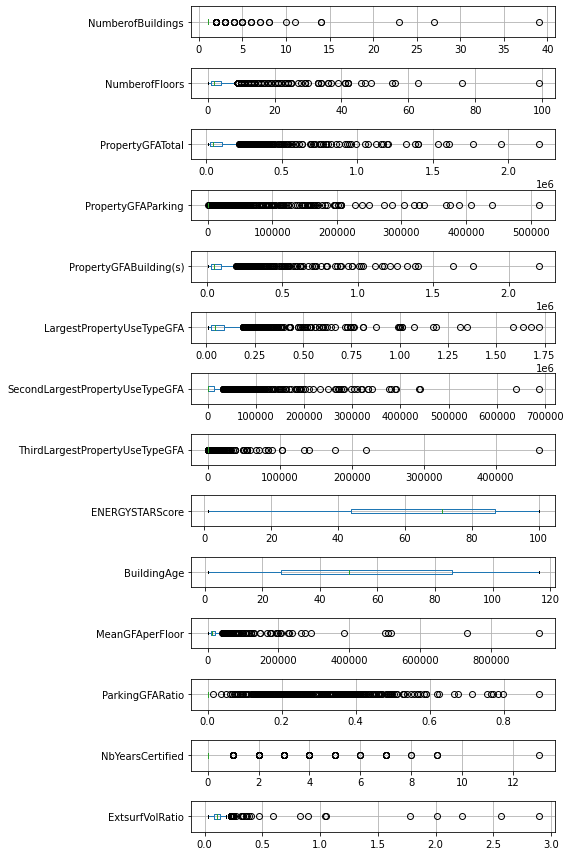

In [ ]:
# fig, axs = plt.subplots(len(df[prop_Q_cols].columns),1,
#                         figsize=(8, 12), sharey=False)
# for c, ax in zip(df[prop_Q_cols].columns, axs):
#     df.boxplot(c, vert=False, ax=ax)
# fig.tight_layout(h_pad=0.051)
# if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_boxplots.png',
#                              dpi=400);
# plt.show()

target features

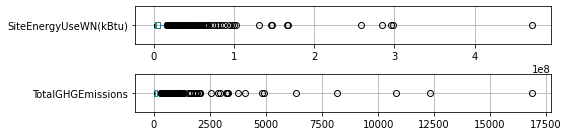

In [ ]:
# fig, axs = plt.subplots(len(df[['SiteEnergyUseWN(kBtu)',
#                                 'TotalGHGEmissions']].columns),1,
#                         figsize=(8, 2), sharey=False)
# for c, ax in zip(df[['SiteEnergyUseWN(kBtu)',
#                      'TotalGHGEmissions']].columns, axs):
#     df.boxplot(c, vert=False, ax=ax)
# fig.tight_layout(h_pad=0.051)
# if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_boxplots_target.png',
#                              dpi=400);
# plt.show()

#### Histograms

Plotting histograms of the main quantitative continuous columns.

* Histograms of independant features

In [ ]:
# (prop_Q_cols)

In [ ]:
# # All the data (with outliers)
# plot_histograms(df=df, cols=prop_Q_cols, file_name='2_1_histograms.png',
#                 figsize=(15,8), bins=30, layout=(4,4), skip_outliers=False,
#                 thresh=30, save_enabled=False)

In [ ]:
# # Excluding outliers to get a better scale
# plot_histograms(df=df, cols=prop_Q_cols, file_name='2_1_histograms.png',
#                 figsize=(15,8), bins=30, layout=(4,4), skip_outliers=True,
#                 thresh=2, save_enabled=False)

* Histograms of target features

In [ ]:
# plot_histograms(df=df, cols=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'],
#                 file_name='2_1_histograms_target.png',
#                 figsize=(7,3), layout=(1,2),  skip_outliers=True,
#                 thresh=1.5, save_enabled=save_enabled)

* QQ plots and normality tests of the independant features

In [ ]:
# for i, c in enumerate(df[prop_Q_cols].columns,1):
#     plot_hist_qqplot(df[c].dropna().values, c, save=False)
#     plt.show()
#     with pd.option_context('display.float_format', '{:,.3f}'.format):
#         display(normality_tests(df[c], print_opt=False))

None of the quantitative independant data have normal distribution.

#### Correlations

Linear correlation (Pearson)

In [ ]:
# pears_corr = df[prop_Q_cols+['SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)_log',
#                              'TotalGHGEmissions', 'TotalGHGEmissions_log']].corr()
# plot_heatmap(pears_corr, shape='tri',
#              title="Pearson correlation", figsize=(12,5))
# if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pearson.png',
#                              dpi=400);
# plt.show()

Correlation tests between independant features

In [ ]:
# test_couples = [('PropertyGFATotal','PropertyGFABuilding(s)'),
#                 ('PropertyGFATotal','LargestPropertyUseTypeGFA'),
#                 ('PropertyGFATotal','NumberofFloors'),
#                 ('PropertyGFATotal','PropertyGFAParking'),
#                 ('ParkingGFARatio','PropertyGFAParking'),
#                 ('NumberofFloors','LargestPropertyUseTypeGFA'),
#                 ('MeanGFAperFloor','PropertyGFABuilding(s)'),
#                 ('SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'),
#                 ('NumberofFloors','PropertyGFABuilding(s)'),
#                 ('ParkingGFARatio','BuildingAge'),
#                 ('NumberofFloors','BuildingAge'),
#                 ('NumberofBuildings','NbYearsCertified')]

# for tup in test_couples:
#     print('------'+str(tup).upper()+'-----')
#     c1, c2 = tup
#     display(correlation_tests(df[c1], df[c2], print_opt=False))
# del tup

#### PCA

In [ ]:
# np.set_printoptions(formatter={'float': '{: 6.2f}'.format})
# df_pca = df.loc[:, prop_Q_cols].dropna(how='any')
# id_code = df_pca.index
# X = df_pca.values

# X_sc = StandardScaler().fit_transform(X)

# n_comp = 11
# pca = PCA(n_components=n_comp).fit(X_sc)

# pca_df = pd.DataFrame(pca.components_,
#                       index=['PC'+str(i+1) for i in range(n_comp)],
#                       columns=prop_Q_cols).T

# X_proj = pca.transform(X_sc)

Plotting principal components

In [ ]:
# plot_heatmap(pca_df,'Principal components coefficients', vmin=-1, vmax=1, center=0,
#              palette=sns.color_palette("coolwarm", 20),figsize=(8,4),shape='rect')
# if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pca_princ_comp.png',
#                              dpi=400);
# plt.show()

Plotting explained variance ratio in scree plot

In [ ]:
# exp_var_rat = pca.explained_variance_ratio_
# scree_plot(col_names= pca_df.columns, exp_var_rat=exp_var_rat,
#            ylim=(0,0.6), figsize=(5,2.5))
# if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_scree_plot.png',
#                              dpi=400);
# plt.show()

First 4 principal components explain 78% of the variance of the data.
We may try to use the principal components later for our model.

In [ ]:
# figure, correlation_matrix = \
#      plot_pca_correlation_graph(X = X_sc, variables_names = prop_Q_cols,
#                                 dimensions=(1, 2), figure_axis_size=6)
#                                 # X_pca = X_proj[:,0:2],
#                                 # explained_variance = exp_var_rat[0:2])
# if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pca_corr_cir_1-2.png',
#                              dpi=400);
# plt.show()

In [ ]:
# figure, correlation_matrix = \
#      plot_pca_correlation_graph(X = X_sc, variables_names = prop_Q_cols,
#                                 dimensions=(3, 4), figure_axis_size=6)#,
#                                 # X_pca = X_proj[:,2:4],
#                                 # explained_variance = exp_var_rat[2:4])
# if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_1_pca_corr_cir_3-4.png',
#                              dpi=400);
# plt.show()

In [ ]:
# plot_heatmap(correlation_matrix.T,'PCA Correlation matrix',
#              vmin=-1, vmax=1, center=0,
#              palette=sns.color_palette("seismic", 20),
#              figsize=(12,1.7),shape='rect')
# plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4'])
# if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_1_correaltion_matrix.png',
#                              dpi=400);
# plt.show()

### 2.2 Categorical data

#### Bar plots

In [ ]:
# plot_barplots(df=df, cols=prop_C_cols, figsize=(12,10),
#               file_name = '2_2_bar_plots.png',
#               layout=(4,3), save_enabled=save_enabled)
# plt.show()

#### Predictive Power Score

Predictive Power Score on main features (ppscore)

In [ ]:
# pps_corr = pps.matrix(df[prop_Q_cols+prop_C_cols+['SiteEnergyUseWN(kBtu)',
#                                                    'SiteEnergyUseWN(kBtu)_log',
#                                                    'TotalGHGEmissions',
#                                                    'TotalGHGEmissions_log']])
# plot_heatmap(pps_corr, title="Predictive Score", 
#              vmin=0, center=0.5, vmax=1, figsize=(12,7), shape='rect',
#              palette=sns.color_palette("Oranges", 10))
# if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+'2_2_ppscore.png',
#                              dpi=400);
# plt.show()

In [ ]:
speak("data exploration: done")

## 3 Exporting the cleaned, merged, filtered, imputed dataset

In [ ]:
# if is_colab==True:
#     path_csv = 'DATA/Cleaned_data.csv' 
#     # Exporting database to my Drive
#     print("2. Try to export from notebook to myDrive...")
# else:
#     path_csv = '../DATA/Cleaned_data.csv'
#     # Exporting database to a DATA directory
#     print("2. Try to export from notebook to PC ('DATA')")

# df.to_csv(path_csv)

# print("-----> exportation of .csv from notebook OK")

2. Try to export from notebook to myDrive...
-----> exportation of .csv from notebook OK


In [ ]:
speak('exportation of cleaned data: done')